In [8]:
### mports ###
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, log, sqrt
from scipy.special import erf
from scipy.linalg import solve_banded


In [9]:
#### Black-Scholes ####
def bsexact(sigma: float, R: float, K: float, T: float, s: float):
    d1 = (log(s/K)+(R+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    F = 0.5*s*(1+erf(d1/sqrt(2)))-exp(-R*T)*K*0.5*(1+erf(d2/sqrt(2)))
    return F

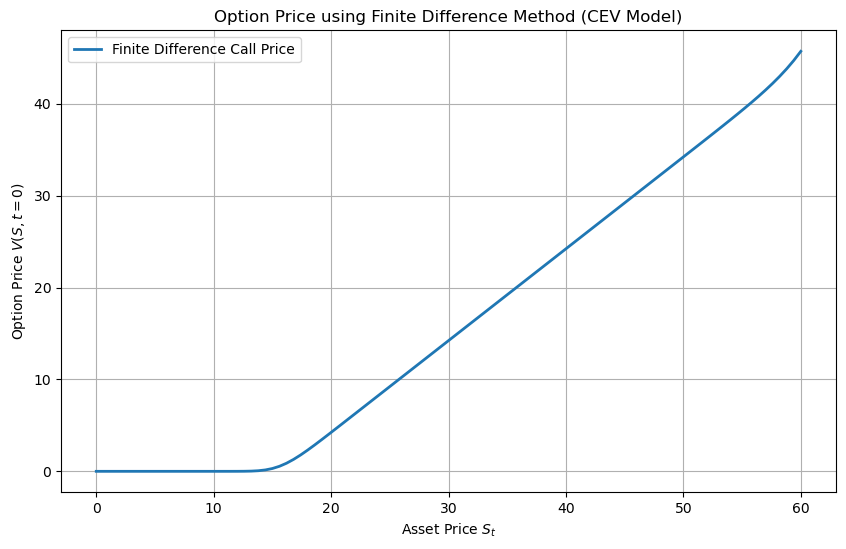

In [6]:
### FD Explicit Method ###

# Finite difference parameters
K = 15          # Strike price
S_max = 4 * K    # Maximum asset price
S_min = 0       # Minimum asset price
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.8     # Elasticity parameter (CEV model)
T = 0.5         # Time to maturity
t_0 = 0         # Initial time
N_s = 100       # Number of asset price grid points
N_t = 500       # Number of time steps

# Discretization of asset price and time
dS = (S_max - S_min) / N_s
dt = T / N_t

# Asset price grid
S = np.linspace(S_min, S_max, N_s+1)

# Time grid
t = np.linspace(t_0, T, N_t+1)

# Initialize the option price matrix
V = np.zeros((N_s+1, N_t+1))

# Payoff at maturity (t = T) for a European call option
V[:, -1] = np.maximum(S - K, 0)

# Boundary conditions
V[0, :] = 0  # V(S=0, t) = 0 for a call option
V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

# Vectorized Finite difference loop (explicit method)
for j in reversed(range(N_t)):  # Loop over time from T to 0
    delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
    gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

    # CEV-based sigma term (S^gamma)
    diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
    drift_term = r * S[1:-1] * delta
    discount_term = r * V[1:-1, j+1]

    # Update option value using finite differences (vectorized)
    V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

# Extract the option prices at time t=0
option_price_finite_diff = V[:, 0]

# Plot the option price as a function of asset price
plt.figure(figsize=(10, 6))
plt.plot(S, option_price_finite_diff, label="Finite Difference Call Price", lw=2)
plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Finite Difference Method (CEV Model)')
plt.legend()
plt.grid(True)
plt.show()

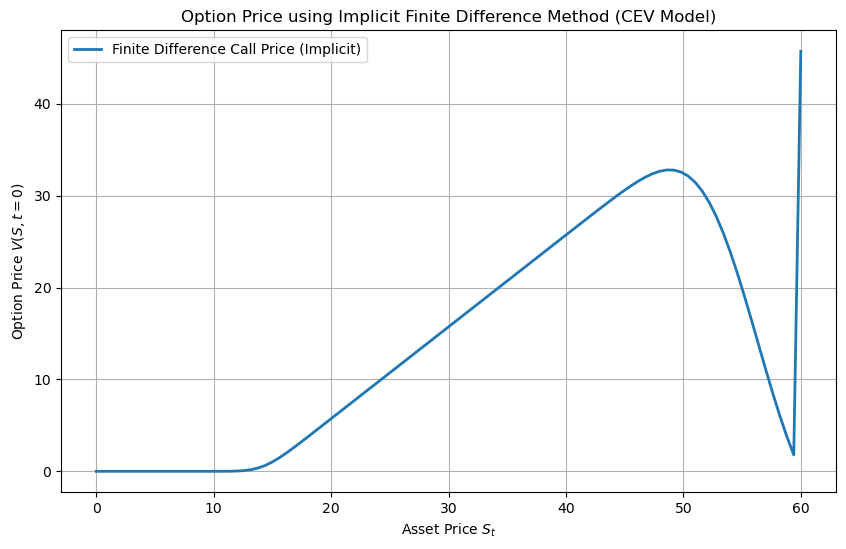

In [7]:
### FD Implicit Method ###

# Finite difference parameters
K = 15          # Strike price
S_max = 4 * K    # Maximum asset price
S_min = 0       # Minimum asset price
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.8     # Elasticity parameter (CEV model)
T = 0.5         # Time to maturity
t_0 = 0         # Initial time
N_s = 100       # Number of asset price grid points
N_t = 500       # Number of time steps

# Discretization of asset price and time
dS = (S_max - S_min) / N_s
dt = T / N_t

# Asset price grid
S = np.linspace(S_min, S_max, N_s+1)

# Time grid
t = np.linspace(t_0, T, N_t+1)

# Initialize the option price matrix
V = np.zeros((N_s+1, N_t+1))

# Payoff at maturity (t = T) for a European call option
V[:, -1] = np.maximum(S - K, 0)

# Boundary conditions
V[0, :] = 0  # V(S=0, t) = 0 for a call option
V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

# Construct the tridiagonal matrix coefficients
alpha = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 - r * S[1:-1] / dS)
beta = -dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r)
gamma_term = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r * S[1:-1] / dS)

# Prepare the diagonals for the banded solver (for tridiagonal matrix)
lower_diag = -alpha[1:]  # lower diagonal (sub-diagonal)
main_diag = 1 - beta     # main diagonal
upper_diag = -gamma_term[:-1]  # upper diagonal (super-diagonal)

# Implicit method: solve the system at each time step
for j in reversed(range(N_t)):  # Loop over time from T to 0
    # Construct the RHS (right-hand side) as the current values of V[:, j+1]
    rhs = V[1:-1, j+1]

    # Solve the linear system: A * V[:, j] = V[:, j+1]
    ab = np.zeros((3, len(main_diag)))
    ab[0, 1:] = upper_diag  # upper diagonal
    ab[1, :] = main_diag    # main diagonal
    ab[2, :-1] = lower_diag  # lower diagonal

    V[1:-1, j] = solve_banded((1, 1), ab, rhs)

# Extract the option prices at time t=0
option_price_finite_diff = V[:, 0]

# Plot the option price as a function of asset price
plt.figure(figsize=(10, 6))
plt.plot(S, option_price_finite_diff, label="Finite Difference Call Price (Implicit)", lw=2)
plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Implicit Finite Difference Method (CEV Model)')
plt.legend()
plt.grid(True)
plt.show()

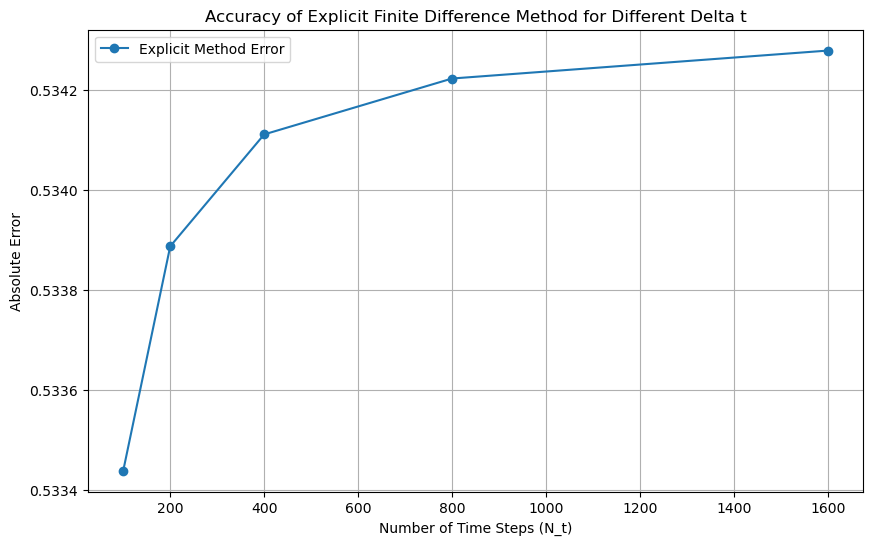

In [10]:
### Accuracy FD Explicit dt ###

# Function to compute option price using explicit finite difference method (for gamma = 1)
def finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    # Discretization of asset price and time
    dS = S_max / N_s
    dt = T / N_t

    # Asset price grid
    S = np.linspace(0, S_max, N_s+1)

    # Time grid
    t = np.linspace(0, T, N_t+1)

    # Initialize the option price matrix
    V = np.zeros((N_s+1, N_t+1))

    # Payoff at maturity (t = T) for a European call option
    V[:, -1] = np.maximum(S - K, 0)

    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

    # Finite difference loop (explicit method)
    for j in reversed(range(N_t)):  # Loop over time from T to 0
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

        # CEV-based sigma term (S^gamma)
        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        # Update option value using finite differences (vectorized)
        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S  # Return option prices at t=0 and asset prices

# Parameters
K = 15
S_max = 4 * K
r = 0.1
sigma = 0.25
gamma = 1  # Gamma = 1 for Black-Scholes
T = 0.5
S0 = 14

# Exact Black-Scholes price for gamma = 1
exact_price = bsexact(sigma, r, K, T, S0)

# Range of delta t values (different time steps)
Nt_values = [100, 200, 400, 800, 1600]  # Different grid sizes for time steps
N_s = 100  # Fixed number of asset price grid points

# Store the errors for each delta t
errors = []

# Loop over different values of N_t
for N_t in Nt_values:
    # Compute the finite difference option price
    fd_price, S_grid = finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
    
    # Find the option price closest to S0 in the finite difference grid
    idx = (np.abs(S_grid - S0)).argmin()  # Find index where S is closest to S0
    fd_price_at_S0 = fd_price[idx]
    
    # Compute the absolute error
    error = np.abs(fd_price_at_S0 - exact_price)
    errors.append((N_t, error))

# Convert errors to a NumPy array for easier manipulation
errors = np.array(errors)

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.plot(errors[:, 0], errors[:, 1], 'o-', label="Explicit Method Error")
plt.xlabel('Number of Time Steps (N_t)')
plt.ylabel('Absolute Error')
plt.title('Accuracy of Explicit Finite Difference Method for Different Delta t')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
### Accuracy FD Explicit ds ###

In [ ]:
### Accuracy FD Implicit dt ###

In [ ]:
### Accuracy FD Implicit ds ###